# Projeto de geometria de torre 525 kV
Torre cross-rope feixe convencional.

Comparação entre critérios de norma

In [1]:
import normaslt as lt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from tabulate import tabulate
from normaslt import nbr1985, nbr5422
from math import ceil, degrees, radians, sin, cos, sqrt, exp
from IPython.display import HTML, display
from normaslt.geral import dbCabo
from normaslt.draw import plot_dimension, plot_feixe, plot_cadeia, plot_distance_radius
from normaslt.types import amp, obs

In [2]:
# Dados de projeto
v = 525.
vmax = 550.
ftmo = vmax/v
# Cabo e vão
cond = dbCabo.CAA_RAIL
ncond = 4
esp = 0.457
l = 490
vpvm = 0.7
eds = 0.2
# Variáveis climatológicas e ambientais
tmed = 17.
dra = 0.91
alt = 400
# Estrutura (mastro)
ht = 20.
d = 2.
s = 1.5
angC = 25 # ângulo do cabo da ponta do mastro a fase lateral, em relação a horizontal (graus)
angM = 5 # ângulo do mastro em relação a vertical (graus)
# Sobretensões (pu)
muft = 2.5
muff = 3.56
sigma = 0.1
alpha = 0.5
# Fatores de gaps frente lenta
# "condutor-estrutura lateral"
kgfn = 1.45 + 0.35*(exp(-8. * s/d)-0.2) # Pegando cálculo na ref. Cigre original
kgff = 1.62 # "condutor-condutor", alpha 0.5
# Ventos de projeto (m/s)
V50t10m = 96.0 / 3.6
V30m30s = 135.0 / 3.6
# Temperatura de operação (°C)
ttipn = 50 # 15% risco térmico
ttips = 60 # 5% risco térmico
tlims = 70 # 1% risco térmico
# Cadeia de isoladores
dIsol = 0.280
passoIsol = 0.170
distEscoam = 0.380
Decr = 14 # distância de escoamento (mm/kVff) - poluição muito leve.

## Elementos em comum

### Cadeia de isoladores
(não referenciado na NBR 5422:1985 mas de prática comum)
$$
n = \left\lceil \frac{V_{\max} \, D_{ecr}}{D_{esc}} \right\rceil + n_{ex}
$$
Sendo $V_{\max}$ a tensão operativa máxima de linha, $D_{esc}$ a relação de distância de escoamento, $D_{esc}$ a distância de escoamento por isolador, $n_{ex}$ a previsão de número de isoladores extras e $\lceil x \rceil$ a operação de arredondar para cima.

### Flecha
Pode-se usar aproximação da parábola:
$$
f = \frac{p \, A^2}{8 \, T}
$$
Sendo $p$ o peso linear do cabo (N/m), $A$ o commprimento do vão (m) e $T$ a tração aplicada (N). A partir da flecha de referência (EDS), calcula-se as outras condições de temperatura pelas equações de estado.

In [3]:
# Cadeia de isoladores
nc = ceil(vmax * Decr / (distEscoam * 1e3)) + 1
lcadeia = nc * passoIsol
print(f"Cadeia de {nc} isoladores, comprimento {lcadeia} m.")
# Dados catálogo Hubbell (p. 124)
cfop = 2010
cfon = 2080

# Flechas
f18 = lt.geral.flecha2(cond.p, l, cond.T * eds) # Na ref. indica 21 m, não ficou claro qual foi a condição, aparentemente em torno de 50°C.
f50, _ = lt.geral.equacaoEstado(cond.p, l, cond.T * eds, cond.S, cond.E, cond.alfa1, 17, ttipn)
f60, _ = lt.geral.equacaoEstado(cond.p, l, cond.T * eds, cond.S, cond.E, cond.alfa1, 17, ttips)
f70, _ = lt.geral.equacaoEstado(cond.p, l, cond.T * eds, cond.S, cond.E, cond.alfa1, 17, tlims)
print(f"Flechas: EDS {f18:.2f} m, 50ºC: {f50:.2f} m, 60ºC: {f60:.2f} m, 70ºC: {f70:.2f} m.")


Cadeia de 22 isoladores, comprimento 3.74 m.
Flechas: EDS 19.72 m, 50ºC: 21.13 m, 60ºC: 21.55 m, 70ºC: 21.96 m.


## Parte 1 - versão 1985

### Altura condutor-solo (seção 10.3)

#### Método convencional:
$$
D = a + 0.01 \left( \frac{D_U}{\sqrt 3} - 50 \right)
$$

Sendo $D_U =$ 1 m/kV referente a tensão máxima fase-fase da linha, $a =$ 6.0 m para locais acessíveis a pedestres.

#### Método alternativo:
$$
D = a_1 + b \, c \left[ \left(  \frac{\sqrt{2 \, D_U}}{\sqrt 3} P_U \, + V_L \right) \frac{a_2}{500 \, k}\right]^{1.667}
$$
Sendo $a_2 =$ 1.15, $b =$ 1.03, $V_L =$ 0, e $P_U$ o valor de sobretensão de manobra a 98%. Para locais acessíveis a pedestres, $a_1 =$ 2.8, $c =$ 1.2, $k =$ 1.15.

In [4]:
a = 6.
Du = vmax
d1 = a + 0.01 * (Du/sqrt(3) - 50.)
a1 = 2.8
a2 = 1.15
b = 1.03
c = 1.2
k = 1.
vl = 0.
pu = muft
d2 = a1+b*c*((sqrt(2*Du/3) * pu)*a2/(500*k))**1.667
print(f"Distancias condutor-solo: dConv = {d1:.2f} m, dAlt = {d2:.2f} m.")
d = max(d1, d2)
hTorre = d + f18
print(f"Altura do condutor na torre: {hTorre:.2f} m.")

Distancias condutor-solo: dConv = 8.68 m, dAlt = 2.83 m.
Altura do condutor na torre: 28.39 m.


### Ventos de projeto

Ambas as versões usam o tempo de integração de 30 s. Para a versão de 1985 aplica-se a função correspondente a Figura 1.

Correção pela altura do condutor:
$$
K_{alt} = \left( \frac{z}{10} \right)^\alpha
$$
sendo $\alpha = 1/n =$ 0.16 para cat. B.

In [8]:
h = 17
Vp30s = nbr1985.fatCorrInt(30) * nbr1985.fatCorrAlt(h) * V50t10m
print(f"Vento de projeto, tempo de integração 30 s: {Vp30s:.2f} m/s.")

Vento de projeto, tempo de integração 30 s: 35.25 m/s.


### Ângulo de balanço

Parcela comum às duas versões:

$$
\beta = \tg^{-1} \left( K \frac{q_0 \, d \, L_m}{p \, L_p} \right)
$$

Sendo $V_p$ o vento de projeto para período de integração de 30 s.

Se considerar uma deflexão de linha $\theta$, deve-se adaptar a formulação:
$$
\beta = \tg^{-1} \left[ K \frac{q_0 \, d \, L_m + 2 \, T \sin(0.5 \, \theta)}{p \, L_p} \right]
$$

Ângulos de balanço considerados

* Frequência fundamental: período de retorno mínimo de 10 anos.
* Impulso de frente lenta: período de retorno mínimo de 2 anos.
* Impulso de frente rápida: não considera ação do vento.

In [6]:
mu = 1.22
q050 = mu*Vr^2/(2*9.81)

beta1 = nbr1985.anguloBalanco(v, q0, d, pcond, VpVv=vpvm)


NameError: name 'Vr' is not defined

### Distâncias de segurança (seção 10)

* Distâncias mínimas no suporte: período de retorno de 10 anos.
* Distâncias mínimas entre condutores em suportes diferentes: período de retorno de 10 anos.
* Distâncias mínima condutor-solo ou obstáculos: período de retorno de 50 anos.

Método convencional:
* Distância vertical entre fases, $U >$ 50 kV: não especificado.
* Distâncias fase-terra:
  * Para-raios: $D = 0.22 + 0.01 D_U$
  * Suporte: $D = 0.03 + 0.005 D_U$
  * Estais: $D = 0.09 + 0.006 D_U$

Método alternativo:
* Distâncias horizontais:
$$
D = b \left( \frac{V \, P_U \, a}{500 \, k} \right)^{1.667}
$$
Sendo $a =$ 1.15, $b =$ 1.03 e $k =$ 1.40. 

### Geometria final

In [ ]:
# Posição das fases
xr = 3
x1a = -xr
x2a = -xr
x3a = -xr
x1b = xr
x2b = xr
x3b = xr
# Alturas relativas à fase mais baixa
y1a = 0.
y2a = 3.
y3a = 6.
y1b = 0.
y2b = 3.
y3b = 6.
hm = 1.5 # Altura da ancoragem do isolador de suspensao em relacao ao do line post
alfa = radians(10.) # Angulo vertical do isolador line post
lc = 0.2 # Comprimento da ferragem (m)
f = 10. # Flecha (m)
h = 10. # clearance (m)
# Ângulos de balanço
ang1 = radians(25.)
ang2 = radians(45.)
hbase = h + f + lc
y1t = y1a+hbase
y2t = y2a+hbase
y3t = y3a+hbase

# Estrutura
ltsup = 1.2
ltinf = 1.2
ht = y3t + hm + 0.5

plt.figure()
# Estrutura metalica
plt.plot([-ltinf/2, -ltsup/2], [0, ht],'k-')
plt.plot([ltinf/2, ltsup/2], [0, ht],'k-')
plt.plot([-ltsup/2, ltsup/2], [ht, ht],'k-')
# Misulas
plt.plot([-ltsup/2, x1a], [y1t, y1t],'g-', linewidth=3)
plt.plot([-ltsup/2, x2a], [y2t, y2t],'g-', linewidth=3)
plt.plot([-ltsup/2, x3a], [y3t, y3t],'g-', linewidth=3)
plt.plot([-ltsup/2, x1a], [y1t+hm, y1t],'g-', linewidth=3)
plt.plot([-ltsup/2, x2a], [y2t+hm, y2t],'g-', linewidth=3)
plt.plot([-ltsup/2, x3a], [y3t+hm, y3t],'g-', linewidth=3)
# Solo
plt.plot([-4.5, 4.5], [0, 0],'k-', linewidth=0.5)
plt.plot([x1a, x1a], [y1t, y1t-lc],'bo-')
plt.plot([x2a, x2a], [y2t, y2t-lc],'bo-')
plt.plot([x3a, x3a], [y3t, y3t-lc],'bo-')
plt.plot([x1a, x1a], [y1t-0.2, y1t-lc+0.2],'r-')
plt.plot([x2a, x2a], [y2t-0.2, y2t-lc+0.2],'r-')
plt.plot([x3a, x3a], [y3t-0.2, y3t-lc+0.2],'r-')
plt.plot([x1a, x1a+lc*sin(ang1)], [y1t, y1t-lc*cos(ang1)],'ro-')
plt.plot([x2a, x2a+lc*sin(ang1)], [y2t, y2t-lc*cos(ang1)],'ro-')
plt.plot([x3a, x3a+lc*sin(ang1)], [y3t, y3t-lc*cos(ang1)],'ro-')
plt.gca().add_patch(patches.Arc((x1a, y1t), 2*lc, 2*lc, theta1=-90., theta2=degrees(ang1)-90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x2a, y2t), 2*lc, 2*lc, theta1=-90., theta2=degrees(ang1)-90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x3a, y3t), 2*lc, 2*lc, theta1=-90., theta2=degrees(ang1)-90.,lw=0.5,color='r'))
# Espaçamentos
dist1 = 1.
dist2 = 2.
plt.gca().add_patch(patches.Arc((x1a+lc*sin(ang1), y1t-lc*cos(ang1)), 2*dist1, 2*dist1, theta1=-90., theta2=90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x2a+lc*sin(ang1), y2t-lc*cos(ang1)), 2*dist1, 2*dist1, theta1=-90., theta2=90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x3a+lc*sin(ang1), y3t-lc*cos(ang1)), 2*dist1, 2*dist1, theta1=-90., theta2=90.,lw=0.5,color='r'))

# teste de cota
plot_dimension(plt, (x1a,y1t-lc), (x2a,y2t-lc), offset=1)
plot_dimension(plt, (x2a,y2t-lc), (x3a,y3t-lc), offset=1)
plot_dimension(plt, (x1a,y1t), (-ltsup/2,y1t), offset=-1.5)
plt.axis('equal')
plt.gca().set_ylim(18, ht+0.5)
plt.show()

## Parte 2 - versão 2024

### Altura condutor-solo (seção 7.2)

A título de exemplo, considerando aqui somente a altura típica nominal (a rigor deve-se observar as quatro condições):
$$
D_{Vtip,n} = P_{bV} + P_{stip} + P_{etip,n}
$$

Para a mesma premissa de acesso somente a pedestres: $k_g =$ 1.47, $P_{bV} =$ 4.20 m. A parcela elétrica $P_{etip,n}$ é calculada para a sobretensão de frente lenta (seção 9.4.1):
$$
P_e = 2.174 \left[ \exp \left( \frac{K_{CS} \, \sqrt 2 \, U_S \, F_{Sfl}}{1080 \, \sqrt 3 \, k_{afl} \, k_{zfl} \, k_g}\right) - 1\right]
$$
Usando $k_{zfl} = 1 - 1.3 \times 0.06$, recomendado pela norma, $K_{CS} = $ 1.35 (seção 7.2.5.1) e estimando $k_{afl}$ para uma distância de 10 m.

In [5]:
umidAbs = nbr5422.umidAbs(dra, tmed)
kafl = nbr5422.fatAtmFrenteLenta(dra, umidAbs, 10.) 
h, Petip, Pelim = nbr5422.distSegurancaVert(obs.PEDESTRE, amp.TIPICA_NOMINAL, 0.0, v, muft, kafl)
print(f"Altura mínima condutor-solo: {h:.2f} m. Parcelas elétricas: Petip = {Petip:.2f} m, Pelim = {Pelim:.2f} m")
hTorre = h + f18
print(f"Altura do condutor na torre: {hTorre:.2f} m.")

Altura mínima condutor-solo: 7.86 m. Parcelas elétricas: Petip = 2.34 m, Pelim = 2.16 m
Altura do condutor na torre: 27.58 m.


### Ventos de projeto

Para a versão 2024 aplica-se o fator de turbulência $K_{tur}$, considerado para a região Sul igual a 1.08, e o fator de integração $K_{int} =$ 1.22.
$$
V_{P30s} = K_{int} K_{tur} V_R
$$

In [6]:
ktur = 1.08
h = 17.0 # Altura preliminar do cabo condutor
Vp30s = nbr5422.fatCorrInt30s() * nbr5422.fatCorrAlt(h) * nbr5422.fatTurb(lt.types.regiao.S) * V50t10m
print(f"Vento de projeto, tempo de integração 30 s: {Vp30s:.2f} m/s.")

Vento de projeto, tempo de integração 30 s: 38.25 m/s.


### Ângulo de balanço

Para a versão 2024 aplica-se o desvio padrão para o ângulo máximo:
$$
\begin{align*}
\sigma_\beta & = 2.25 \left[1 - \exp \left( -\frac{V_p^2}{230}\right) \right] \\
\beta_{\max} & = \beta + 2 \sigma_\beta
\end{align*}
$$

Ângulos de balanço considerados (seção 9.6.2)

* Frequência fundamental: período de retorno mínimo de 10 anos.
* Impulso de frente lenta: período de retorno mínimo de 2 anos.
* Impulso de frente rápida: não considera ação do vento.

In [7]:
mu = nbr5422.massaAr(alt, tmed)
q050 = 0.5*mu*Vp30s**2
print(f"Pressão de vento: {q050:.2f} N/m²")
beta1 = nbr5422.anguloBalanco(Vp30s, q050, cond.d, cond.p, VpVv=vpvm)
betamin, betamax = nbr5422.anguloBalancoAssincrono(Vp30s, beta1) 
print(f"Ângulo de balanço médio {degrees(beta1):.1f}°, máximo {degrees(betamax):.1f}º.")

Pressão de vento: 848.21 N/m²
Ângulo de balanço médio 35.1°, máximo 39.6º.


### Geometria da torre

#### Coordenação de isolamento (seção 9)

In [8]:
# Isolamento na tensão máxima frequência industrial
kg = 1.35 * kgfn - 0.35 * kgfn**2
dft = nbr5422.espacFTFreqFund(Us=v, Ftmo=ftmo, kaff=1., kgff=kg, zff=0.)
kg = 1.35 * kgff - 0.35 * kgff**2
dff = nbr5422.espacFFFreqFund(Us=v, Ftmo=ftmo, kaff=1., kgff=kg, zff=0.)
print(f"Distâncias para isolamento a frequência industrial: fase-terra {dft:.2f} m, fase-fase {dff:.2f} m.")

Distâncias para isolamento a frequência industrial: fase-terra 0.80 m, fase-fase 1.34 m.


In [9]:
# Isolamento a sobretensões de frente lenta
# Energização
kcs = 1.178
fsfl = 2.18
dft = nbr5422.espacFTFrenteLenta(Us=v, Kcs=kcs, Fsfl=fsfl, kafl=0.93, kg=kgfn)
fsfl = 2.7
dff = nbr5422.espacFFFrenteLenta(Us=v, Kcs=kcs, Fsfl=fsfl, kafl=0.93, kg=kgff, alpha=alpha)
print(f"Distâncias para isolamento sobretensões frente lenta: fase-terra {dft:.2f} m, fase-fase {dff:.2f} m.")

Distâncias para isolamento sobretensões frente lenta: fase-terra 2.03 m, fase-fase 1.98 m.


In [ ]:
# Isolamento a sobretensões de frente rápida
bilp = cfop * (1 - 1.28*0.03)
biln = cfon * (1 - 1.28*0.03)
dftp = nbr5422.espacFTFrenteRapidaPos(bilp, kafr=dra, kg=kgfn) 
dftn = nbr5422.espacFTFrenteRapidaNeg(biln, kafr=dra, kg=kgfn) 
dff = nbr5422.espacFFFrenteRapida(bilp, kafr=dra, kg=kgff)
print(f"Distâncias para isolamento sobretensões frente lenta: fase-terra positiva {dftp:.2f} m, negativa {dftn:.2f} m, fase-fase {dff:.2f} m.")


Distâncias para isolamento sobretensões frente lenta: fase-terra positiva 3.79 m, negativa 4.04 m, fase-fase 4.31 m.


#### Levantamento do ponto mais a direita para locação do mastro _cross-rope_

#### Esboço da cabeça da torre

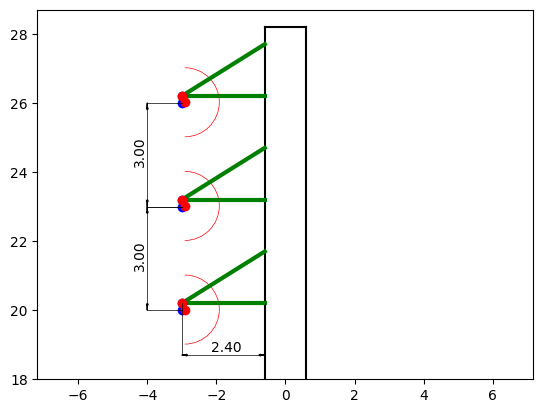

In [ ]:
# Plotagem - torre 525 kV cross-rope

# Posição das fases
xr = 3
x1a = -xr
x2a = -xr
x3a = -xr
x1b = xr
x2b = xr
x3b = xr
# Alturas relativas à fase mais baixa
y1a = 0.
y2a = 3.
y3a = 6.
y1b = 0.
y2b = 3.
y3b = 6.
hm = 1.5 # Altura da ancoragem do isolador de suspensao em relacao ao do line post
alfa = radians(10.) # Angulo vertical do isolador line post
lc = 0.2 # Comprimento da ferragem (m)
f = 10. # Flecha (m)
h = 10. # clearance (m)
# Ângulos de balanço
ang1 = radians(25.)
ang2 = radians(45.)
hbase = h + f + lc
y1t = y1a+hbase
y2t = y2a+hbase
y3t = y3a+hbase

# Estrutura
ltsup = 1.2
ltinf = 1.2
ht = y3t + hm + 0.5

plt.figure()
# Estrutura metalica
plt.plot([-ltinf/2, -ltsup/2], [0, ht],'k-')
plt.plot([ltinf/2, ltsup/2], [0, ht],'k-')
plt.plot([-ltsup/2, ltsup/2], [ht, ht],'k-')
# Misulas
plt.plot([-ltsup/2, x1a], [y1t, y1t],'g-', linewidth=3)
plt.plot([-ltsup/2, x2a], [y2t, y2t],'g-', linewidth=3)
plt.plot([-ltsup/2, x3a], [y3t, y3t],'g-', linewidth=3)
plt.plot([-ltsup/2, x1a], [y1t+hm, y1t],'g-', linewidth=3)
plt.plot([-ltsup/2, x2a], [y2t+hm, y2t],'g-', linewidth=3)
plt.plot([-ltsup/2, x3a], [y3t+hm, y3t],'g-', linewidth=3)
# Solo
plt.plot([-4.5, 4.5], [0, 0],'k-', linewidth=0.5)
plt.plot([x1a, x1a], [y1t, y1t-lc],'bo-')
plt.plot([x2a, x2a], [y2t, y2t-lc],'bo-')
plt.plot([x3a, x3a], [y3t, y3t-lc],'bo-')
plt.plot([x1a, x1a], [y1t-0.2, y1t-lc+0.2],'r-')
plt.plot([x2a, x2a], [y2t-0.2, y2t-lc+0.2],'r-')
plt.plot([x3a, x3a], [y3t-0.2, y3t-lc+0.2],'r-')
plt.plot([x1a, x1a+lc*sin(ang1)], [y1t, y1t-lc*cos(ang1)],'ro-')
plt.plot([x2a, x2a+lc*sin(ang1)], [y2t, y2t-lc*cos(ang1)],'ro-')
plt.plot([x3a, x3a+lc*sin(ang1)], [y3t, y3t-lc*cos(ang1)],'ro-')
plt.gca().add_patch(patches.Arc((x1a, y1t), 2*lc, 2*lc, theta1=-90., theta2=degrees(ang1)-90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x2a, y2t), 2*lc, 2*lc, theta1=-90., theta2=degrees(ang1)-90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x3a, y3t), 2*lc, 2*lc, theta1=-90., theta2=degrees(ang1)-90.,lw=0.5,color='r'))
# Espaçamentos
dist1 = 1.
dist2 = 2.
plt.gca().add_patch(patches.Arc((x1a+lc*sin(ang1), y1t-lc*cos(ang1)), 2*dist1, 2*dist1, theta1=-90., theta2=90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x2a+lc*sin(ang1), y2t-lc*cos(ang1)), 2*dist1, 2*dist1, theta1=-90., theta2=90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x3a+lc*sin(ang1), y3t-lc*cos(ang1)), 2*dist1, 2*dist1, theta1=-90., theta2=90.,lw=0.5,color='r'))

# teste de cota
plot_dimension(plt, (x1a,y1t-lc), (x2a,y2t-lc), offset=1)
plot_dimension(plt, (x2a,y2t-lc), (x3a,y3t-lc), offset=1)
plot_dimension(plt, (x1a,y1t), (-ltsup/2,y1t), offset=-1.5)
plt.axis('equal')
plt.gca().set_ylim(18, ht+0.5)
plt.show()

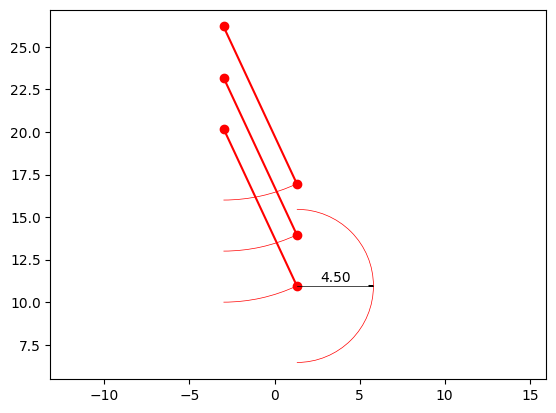

In [6]:
# Meio do vão
y1mv = y1a + h
y2mv = y2a + h
y3mv = y3a + h
l = f + lc
plt.figure()
plt.plot([x1a, x1a+l*sin(ang1)], [y1t, y1t-l*cos(ang1)],'ro-')
plt.plot([x2a, x2a+l*sin(ang1)], [y2t, y2t-l*cos(ang1)],'ro-')
plt.plot([x3a, x3a+l*sin(ang1)], [y3t, y3t-l*cos(ang1)],'ro-')
plt.gca().add_patch(patches.Arc((x1a, y1t), 2*l, 2*l, theta1=-90., theta2=degrees(ang1)-90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x2a, y2t), 2*l, 2*l, theta1=-90., theta2=degrees(ang1)-90.,lw=0.5,color='r'))
plt.gca().add_patch(patches.Arc((x3a, y3t), 2*l, 2*l, theta1=-90., theta2=degrees(ang1)-90.,lw=0.5,color='r'))
plot_distance_radius(plt, (x1a+l*sin(ang1), y1t-l*cos(ang1)), radius=4.5)
plt.axis('equal')
plt.show()